# Load and save **jinns** models

In this notebook we demonstrate how to save and reload trained **jinns** models. 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Import our package

In [2]:
import jinns

Import other dependencies

In [3]:
import jax
from jax import random
import jax.numpy as jnp
import equinox as eqx

key = random.PRNGKey(2)

2024-11-18 13:05:59.970524: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version 12.3.107. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Training 

Create the neural network architecture for the PINN and the dictionary of parameters

In [4]:
eqx_list = (
    (eqx.nn.Linear, 2, 128),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 128, 128),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 128, 128,),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 128, 1)
)
key, subkey = random.split(key)
u_pinn, nn_init_params = jinns.nn.PINN_MLP.create(key=subkey, eqx_list=eqx_list, eq_type="nonstatio_PDE")

In [5]:
params_pinn = jinns.parameters.Params(
    nn_params=nn_init_params,
    eq_params={}
)

In [6]:
nx = 500
val_xdata = jnp.linspace(0, 1, nx)
ntime = 500
val_times = jnp.linspace(0, 1, ntime)

Plot the random initialisation

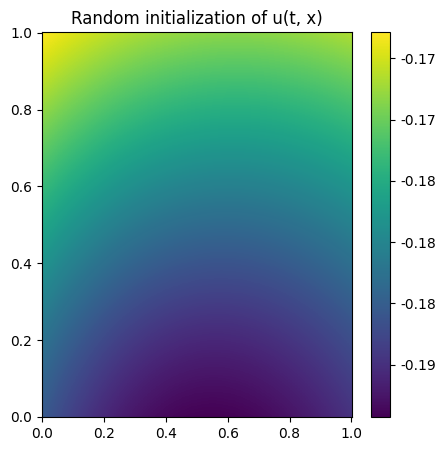

In [7]:
u_est_pinn = lambda t_x:u_pinn(t_x, params_pinn.nn_params)
# same subkey
jinns.plot.plot1d_image(u_est_pinn, xdata=val_xdata, times=val_times, cmap="viridis", colorbar=True, figsize=(5, 5), title="Random initialization of u(t, x)")

## Train the model and do stuff

In [8]:
# Your code here

## Save the model

You will need to use the new functions `jinns.utils.save_pinn` and `jinns.utils.load_pinn`. Documentation is available.

The save function takes 4 arguments as input:

- A filename prefix
- The PINN model
- The PINN's `Params` or `ParamsDict` object
- A dictionary listing the arguments that were used to create the PINN model

The save function will then save 3 files that will be used for reloading the model. You can share these files to disseminate your model:

- A file `{filename}-module.eqx`: this stores the PINN model which is an `equinox` Module (stores all the attributes of the module except the parameters). In the case of a ParamsDict, this would be `{filename}-module{key}.eqx` with `key` from the dictionary `ParamsDict.nn_params`.
- A file `{filename}-eq_params.pkl`: this stores the dictionary of parameters of the equation
- A file `{filename}-arguments.pkl`: this stores the dictionary of arguments used to create the equinox module

In [9]:
from jinns.utils import save_pinn, load_pinn

In [10]:
filename = "./test_pinn"
kwargs_creation = {
    "key": subkey,
    "eqx_list": eqx_list,
    "eq_type":"nonstatio_PDE",
    "dim_x":1
}
save_pinn(filename, u_pinn, params_pinn, kwargs_creation)

## Reload model

The `jinns.utils.load_pinn` function returns a pair: the PINN module and the parameters that were saved. You just need to pass a filename prefix and the function will look for the `{filename}-module.eqx`, `{filename}-eq_params.pkl` and `{filename}-arguments.pkl` files. You also need to pass the `type_` arguments which specifies which kind of PINN model you want to load (either a vanilla PINN, a SPINN or an HyperPINN).

In [11]:
u_pinn_reloaded, params_pinn_reloaded = load_pinn(filename, type_="pinn")

Sanity check that we reload the expected model:

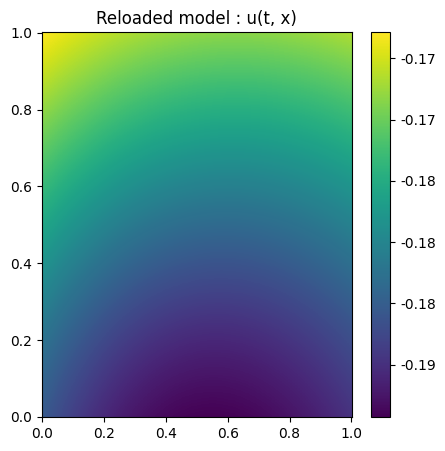

In [12]:
u_est_pinn_reloaded = lambda t_x:u_pinn_reloaded(t_x, params_pinn_reloaded.nn_params)
# same subkey
jinns.plot.plot1d_image(u_est_pinn_reloaded, xdata=val_xdata, times=val_times, cmap="viridis", colorbar=True, figsize=(5, 5), title="Reloaded model : u(t, x)")

In [13]:
diff = lambda t_x: u_pinn_reloaded(t_x, params_pinn_reloaded.nn_params) - u_pinn(t_x, params_pinn.nn_params)

diff = jax.vmap(diff, (0,))

key, subkey = jax.random.split(key, 2)
t_x = jax.random.uniform(subkey, (1000,2))

jnp.allclose(diff(t_x), 0)


Array(True, dtype=bool)

## A second example with hyperPINN (metamodeling)

When using an hypernetwork and the `HyperPINN` class, the reloading step must specify the `type_="hyperpinn"` argument.

In the following example, we demonstrate a use-case with an hypernetwork solving for a family equation with two equation parameters `D` and `r`. 

In [14]:
eqx_list = (
    (eqx.nn.Linear, 3, 16),
    (jax.nn.swish,),
    (eqx.nn.Linear, 16, 16),
    (jax.nn.swish,),
    (eqx.nn.Linear, 16, 1),
)

eqx_list_hyper = (
    (eqx.nn.Linear, 2, 32), # input is of size 2 for scalar D and scalar r
    (jax.nn.tanh,),
    (eqx.nn.Linear, 32, 32),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 32, 1000), # 1000 is a random guess, it will automatically be filled with the correct value
)

key, subkey = random.split(key)

hyperparams = ["D", "r"]
hypernet_input_size = 2

dim_x = 2

u_hpinn, init_nn_params = jinns.nn.HYPERPINN.create(key=subkey, eqx_list=eqx_list, eq_type="nonstatio_PDE", hyperparams=hyperparams, hypernet_input_size=hypernet_input_size, eqx_list_hyper=eqx_list_hyper)

In [15]:
key, *subkeys = random.split(key,3)

omega_batch_size = 32
times_batch_size = 32
param_batch_size = omega_batch_size * times_batch_size

init_params_hpinn = jinns.parameters.Params(
    nn_params=init_nn_params,
    eq_params={
        "D": jax.random.uniform(subkeys[0], (param_batch_size,)),
        "r": jax.random.uniform(subkeys[1], (param_batch_size,)),
        "g":jnp.array([1.]),
    }
)

### Train the model and do stuff

In [16]:
# YOUR CODE HERE

### Saving

Saving is the handled exactly the same

In [17]:
filename = f"./test_hyperpinn"
kwargs_creation = {
    "key": subkey,
    "eqx_list": eqx_list,
    "eq_type":"nonstatio_PDE",
    "hyperparams":hyperparams,
    "hypernet_input_size": hypernet_input_size,
    "dim_x":1,
    "eqx_list_hyper":eqx_list_hyper
}
save_pinn(filename, u_hpinn, init_params_hpinn, kwargs_creation)

### Reloading

Reloading the hypernetwork demands extra-care

In [18]:
u_hpinn_reloaded, params_hpinn_reloaded = jinns.utils.load_pinn(filename, type_="hyperpinn")

In [19]:
###############
# Sanity check


D = jnp.array(1.2)
r = jnp.array(0.5)

def u_metamodel(t_x):
    # Hyperpinn before saving
    params_ = jinns.parameters.Params(
        nn_params=init_params_hpinn.nn_params,
        eq_params= {
            "D": D,
            "r": r,
            "g": jnp.array([1.]),
        }
    )
    return u_hpinn(t_x, params_)

def u_metamodel_reloaded(t_x):
    # Hyperpinn after saving
    params_ = jinns.parameters.Params(
        nn_params=params_hpinn_reloaded.nn_params,
        eq_params= {
            "D": D,
            "r": r,
            "g": jnp.array([1.]),
        }
    )
    return u_hpinn_reloaded(t_x, params_)

key, subkey = jax.random.split(key, 2)
t_x = jax.random.uniform(subkey, (1000,3))

u_metamodel = jax.vmap(u_metamodel, (0,))
u_metamodel_reloaded = jax.vmap(u_metamodel_reloaded, (0,))

jnp.allclose(u_metamodel(t_x), u_metamodel_reloaded(t_x))

Array(True, dtype=bool)